# Langevin Monte Carlo algorithms.

Based on the following but reimplemented in JAX
- [Monte Carlo Sampling using Langevin Dynamics [Blogpost]](https://abdulfatir.com/blog/2020/Langevin-Monte-Carlo/)
  - Accompanying [notebook](https://github.com/abdulfatir/langevin-monte-carlo/blob/c7a0a67807d6807db2e8573b08540b4222acc312/Langevin-Monte-Carlo.ipynb)


More info:
- https://perceptron.blog/langevin-dynamics/
- https://en.wikipedia.org/wiki/Langevin_dynamics
- https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method
- https://en.wikipedia.org/wiki/Fokker%E2%80%93Planck_equation
- https://iclr-blogposts.github.io/2024/blog/diffusion-theory-from-scratch/
- https://bjlkeng.io/posts/bayesian-learning-via-stochastic-gradient-langevin-dynamics-and-bayes-by-backprop/
- https://stats.stackexchange.com/questions/414574/reconciling-langevin-mc-methods-as-one-step-hmc-versus-as-diffusion-or-brownian
- https://physics.stackexchange.com/questions/129510/is-there-a-modern-iteration-of-einsteins-brownian-motion-theory
- [On the Theory of Brownian Motion](https://www.physik.uni-augsburg.de/theo1/hanggi/History/Langevin1908.pdf)

In [1]:
# Avoid JAX from using up all the GPU memory
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
import numpy as np

import jax
import jax.random
import jax.extend
import jax.numpy as jnp

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [3]:
print(f"{jax.__version__=}")
backend = str(jax.extend.backend.get_backend().platform)
print(f"JAX backend: {backend}")

jax.__version__='0.4.35'
JAX backend: gpu


# Langevin Monte Carlo

New samples are proposed by simulating the Langevin Stochastic Differential Equation (SDE) which is given by

$$dX_t = -\nabla U(X_t)dt + \sqrt{2}dB_t$$

where $U$ is the potential function and $B_t$ is the standard Brownian motion.

### Example
Let $U(\mathbf{z}) = \frac{1}{2}\left(\frac{\|\mathbf{z}\|-2}{0.4}\right)^2 - \log\left(e^{-0.5\left[\frac{\mathbf{z}_1 - 2}{0.6}\right]} + e^{-0.5\left[\frac{\mathbf{z}_1 + 2}{0.6}\right]}\right)$, and $p(\mathbf{z}) \propto e^{-U(\mathbf{z})}$ be the distribution we want to sample from.

Let's visualize the (unnormalized) density.

In [4]:
def npdensity1(z):
    z = np.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)

def npdensity2(z):
    z = z.reshape(-1, 2)
    x, y = z[:, 0], z[:, 1]
    u = 0.8 * x ** 2 + (y - ((x**2)**(1/3)))**2
    u = u / 2**2
    return np.exp(-u)

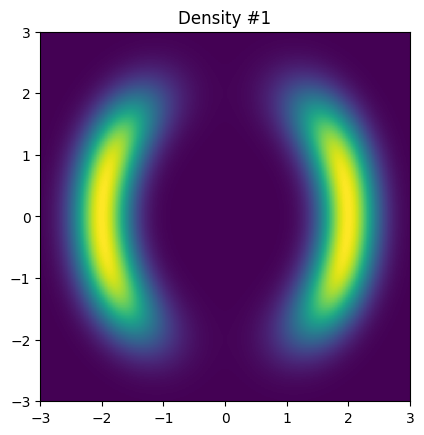

In [5]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity1(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Density #1')
plt.show()

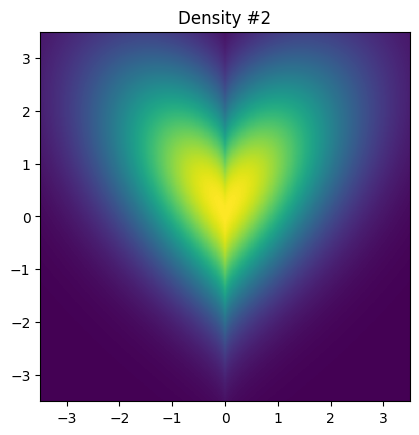

In [6]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity2(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Density #2')
plt.show()

## Unadjusted Langevin Algorithm (ULA)

The Langevin SDE can be simulated using the Euler-Maruyama scheme as follows

$$X_{k+1} = X_{k} - \gamma_{k+1}\nabla U(X_k) + \sqrt{2\gamma_{k+1}}Z_{k+1}$$

where $\gamma_{k+1}$ is the step size and $Z_{k+1}$ is a sample from $\mathcal{N}(0, I)$ respectively at the $k+1$-th time-step.

In practice, there are various tricks to set $\gamma_{k+1}$ and $X_0$, the initial seed. However, in the following examples, I've used a constant step-size and have sampled $X_0$ from $\mathcal{N}(0, I)$.

The above simulation of Langevin dynamics can be used to draw samples from densities of the form $p(x) = \frac{e^{-U(x)}}{Z}$ where Z may or may not be known. It is assumed that the gradient of $U$ is $L$-Lipschtiz. 

In [7]:
def potential1(z):
    z = jnp.reshape(z, (-1, 2))
    z1 = z[:, 0]
    norm = jnp.linalg.norm(z, axis=1)
    exp1 = jnp.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = jnp.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - jnp.log(exp1 + exp2)
    return jnp.mean(u)

def potential2(z):
    z = jnp.reshape(z, (-1, 2))
    x, y = z[:, 0], z[:, 1]
    u = 0.8 * x ** 2 + (y - ((x**2)**(1/3)))**2
    u = u / 2**2
    return jnp.mean(u)

In [8]:

def unadjusted_langevin_algorithm(potential, n_samples=100000, step_size=0.1, rng_key=jax.random.PRNGKey(0)):
    burn_in = 10000
    Z0 = jax.random.normal(key=rng_key, shape=(1, 2))

    @jax.jit
    def body_fun(i, state):
        Zi, rng_key, samples = state
        grad = jax.grad(potential)(Zi)
        new_key, rng_key = jax.random.split(rng_key)
        brownian_noise = jnp.sqrt(2 * step_size) * jax.random.normal(key=new_key, shape=(1, 2))
        Zi = Zi - step_size * grad + brownian_noise
        samples = samples.at[i].set(Zi)
        return Zi, rng_key, samples
    
    samples = jnp.zeros((n_samples + burn_in, 1, 2))
    Zi = Z0
    for i in tqdm(range(n_samples + burn_in)):
        Zi, rng_key, samples = body_fun(i, (Zi, rng_key, samples))
    
    return jnp.reshape(samples[burn_in:], (-1, 2))

samples1 = unadjusted_langevin_algorithm(potential1)
print(f"{samples1.shape=}")
samples2 = unadjusted_langevin_algorithm(potential2)
print(f"{samples2.shape=}")

  0%|          | 0/110000 [00:00<?, ?it/s]

samples1.shape=(100000, 2)


  0%|          | 0/110000 [00:00<?, ?it/s]

samples2.shape=(100000, 2)


Run the ULA and render the empirical density.

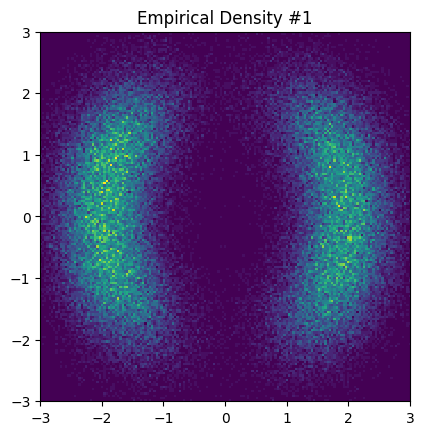

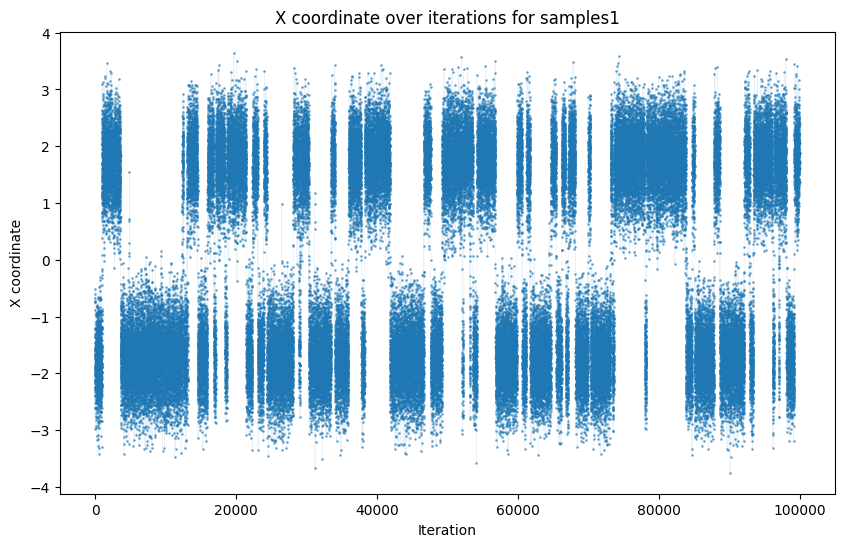

In [9]:
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Empirical Density #1')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(len(samples1)), samples1[:, 0], alpha=0.1, linewidth=0.5)
plt.scatter(range(len(samples1)), samples1[:, 0], alpha=0.5, s=1)
plt.xlabel('Iteration')
plt.ylabel('X coordinate')
plt.title('X coordinate over iterations for samples1')
plt.show()

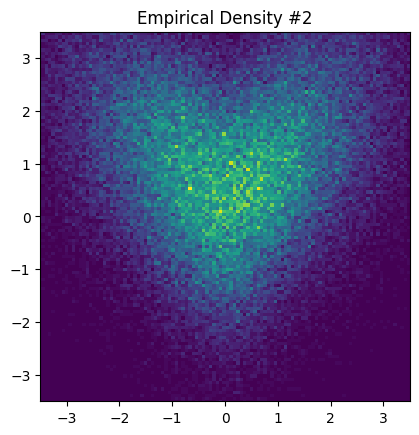

In [10]:
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #2')
plt.show()

## Metropolis-adjusted Langevin Algorithm (MALA)

New samples are proposed using the Euler-Maruyama scheme as before, but are accepted/rejected using the Metropolis-Hastings algorithm, i.e., the acceptance propability is given by

$$\alpha = \min \left\{1, \frac{p(x_{k+1})Q(x_k|x_{k+1})}{p(x_{k})Q(x_{k+1}|x_{k})}\right\}$$

where 

$$Q(x'|x) \propto \exp\left(-\frac{1}{4\gamma}\|x' - x + \gamma\nabla U(x)\|^2\right)$$


More info:
- https://en.wikipedia.org/wiki/Metropolis-adjusted_Langevin_algorithm

Vs HMC:
- https://discourse.mc-stan.org/t/standalone-hmc-sampler/4040/4
- https://discourse.mc-stan.org/t/standalone-hmc-sampler/4040/5

In [11]:
def log_Q(potential, z_prime, z, step):
    grad = jax.grad(lambda x: jnp.mean(potential(x)))(z)
    return -(jnp.linalg.norm(z_prime - z + step * grad, ord=2, axis=1) ** 2) / (4 * step)

def metropolis_adjusted_langevin_algorithm(potential, n_samples=100000, step=0.1):
    burn_in = 10000
    rng_key = jax.random.PRNGKey(0)
    
    @jax.jit
    def body_fun(i, state):
        Zi, rng_key, samples = state
        rng_key, subkey1, subkey2 = jax.random.split(rng_key, 3)
        
        grad = jax.grad(lambda x: jnp.mean(potential(x)))(Zi)
        prop_Zi = Zi - step * grad + jnp.sqrt(2 * step) * jax.random.normal(subkey1, Zi.shape)
        
        log_ratio = -jnp.mean(potential(prop_Zi)) + jnp.mean(potential(Zi)) + \
                    log_Q(potential, Zi, prop_Zi, step) - log_Q(potential, prop_Zi, Zi, step)
        
        accept = jax.random.uniform(subkey2) < jnp.exp(log_ratio)
        Zi = jnp.where(accept, prop_Zi, Zi)
        samples = samples.at[i].set(Zi)
        
        return Zi, rng_key, samples
    
    Z0 = jax.random.normal(rng_key, (1, 2))
    samples = jnp.zeros((n_samples + burn_in, 1, 2))
    Zi = Z0
    
    for i in tqdm(range(n_samples + burn_in)):
        Zi, rng_key, samples = body_fun(i, (Zi, rng_key, samples))
    
    return jnp.reshape(samples[burn_in:], (-1, 2))


samples1 = metropolis_adjusted_langevin_algorithm(potential1)
print(f"{samples1.shape=}")
samples2 = metropolis_adjusted_langevin_algorithm(potential2)
print(f"{samples2.shape=}")

  0%|          | 0/110000 [00:00<?, ?it/s]

samples1.shape=(100000, 2)


  0%|          | 0/110000 [00:00<?, ?it/s]

samples2.shape=(100000, 2)


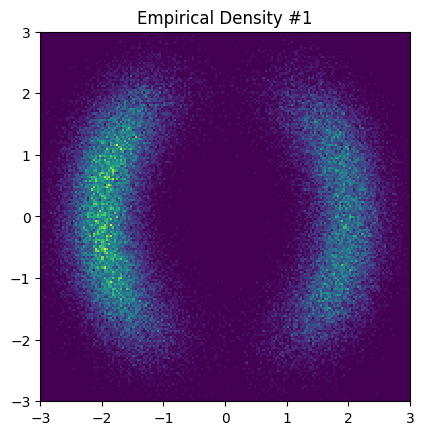

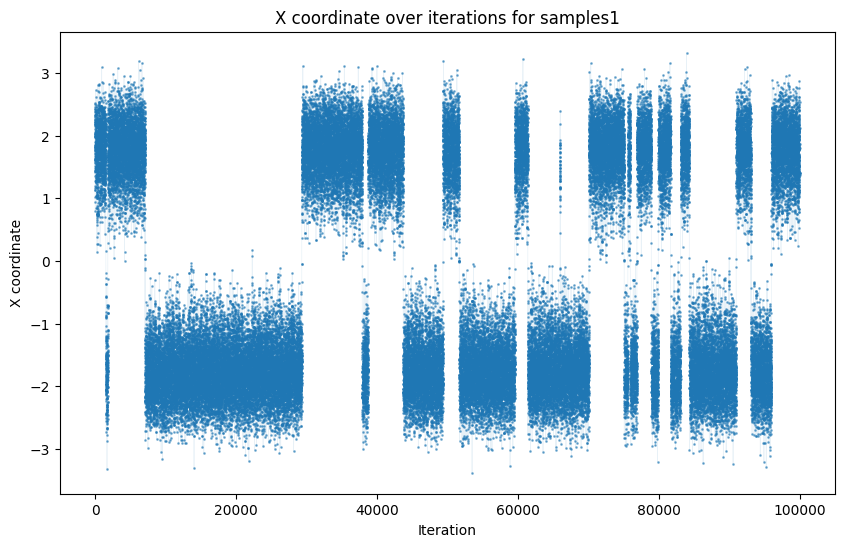

In [12]:
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Empirical Density #1')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(len(samples1)), samples1[:, 0], alpha=0.1, linewidth=0.5)
plt.scatter(range(len(samples1)), samples1[:, 0], alpha=0.5, s=1)
plt.xlabel('Iteration')
plt.ylabel('X coordinate')
plt.title('X coordinate over iterations for samples1')
plt.show()

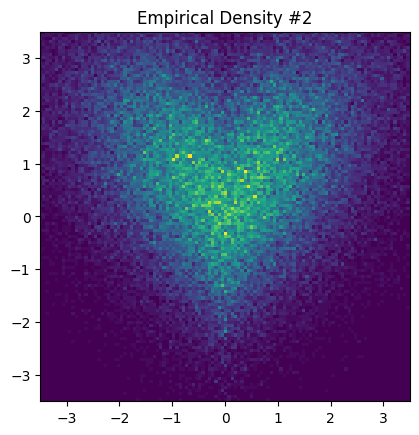

In [13]:
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #2')
plt.show()

## Metropolis-Hastings Algorithm for comparison

In [14]:
def metropolis_hastings(target_density, size=100000):
    burnin_size = 10000
    size += burnin_size
    x0 = np.array([[0, 0]])
    xt = x0
    samples = []
    for i in tqdm(range(size)):
        xt_candidate = np.array([np.random.multivariate_normal(xt[0], np.eye(2))])
        accept_prob = (target_density(xt_candidate))/(target_density(xt))
        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)
    samples = np.array(samples[burnin_size:])
    samples = np.reshape(samples, [samples.shape[0], 2])
    return samples

In [15]:
samples1 = metropolis_hastings(npdensity1)
samples2 = metropolis_hastings(npdensity2)

  0%|          | 0/110000 [00:00<?, ?it/s]

  0%|          | 0/110000 [00:00<?, ?it/s]

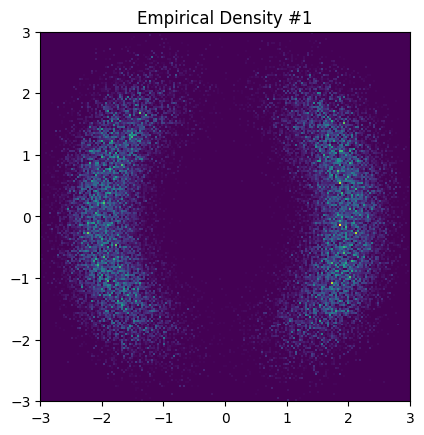

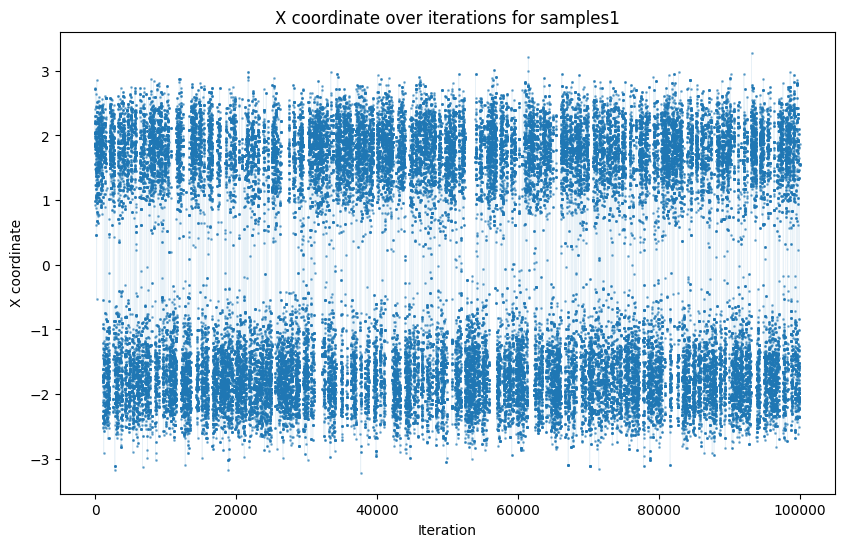

In [16]:
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Empirical Density #1')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(len(samples1)), samples1[:, 0], alpha=0.1, linewidth=0.5)
plt.scatter(range(len(samples1)), samples1[:, 0], alpha=0.5, s=1)
plt.xlabel('Iteration')
plt.ylabel('X coordinate')
plt.title('X coordinate over iterations for samples1')
plt.show()

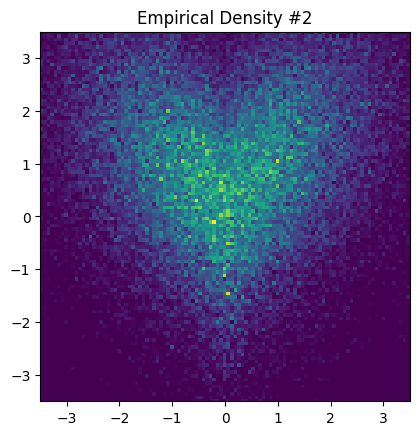

: 

In [17]:
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #2')
plt.show()